# **MAL Project** - Mobile Churn Forecasting
Mattéo Rousseau & Massil Gouachi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import uniform

# Processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.manifold import TSNE

# Model training and evaluation and 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

## **Part I** - Data exploration

In [8]:
# Data Import
cell = pd.read_csv("celldata.csv")

features = [feature for feature in cell.columns if feature != "Churn"]
X, y = cell[features].copy(), cell[["Churn"]].copy()

types = {
    "CreditScore": "int64",
    "Age": "int64",
    "Tenure": "int64",
    "Balance": "float64",
    "NumOfProducts": "int64",
    "Salary": "int64",
    "Geography": "category",
    "Gender": "category",
    "HasCrCard": "boolean",
    "IsActiveMember": "boolean",
}

X = X.astype(types)
y = y.astype({"Churn": "boolean"})

cat_cols = ["Geography", "Gender", "HasCrCard", "IsActiveMember"]
num_cols = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "Salary"]
target = "Churn"

cell.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Salary,Churn
0,632,Germany,Female,50,5,107959.39,1,1,1,6985,1
1,649,France,Female,42,7,0.00,2,0,1,22974,0
2,595,France,Male,29,6,150685.79,1,1,0,87771,0
3,653,Spain,Male,35,6,116662.96,2,1,1,23864,0
4,559,Spain,Female,40,7,144470.77,1,1,1,18918,0


### **1.** Variables Description

In this section, we describe the variables of the dataset.

In [3]:
cell.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CreditScore     8000 non-null   int64  
 1   Geography       8000 non-null   object 
 2   Gender          8000 non-null   object 
 3   Age             8000 non-null   int64  
 4   Tenure          8000 non-null   int64  
 5   Balance         8000 non-null   float64
 6   NumOfProducts   8000 non-null   int64  
 7   HasCrCard       8000 non-null   int64  
 8   IsActiveMember  8000 non-null   int64  
 9   Salary          8000 non-null   int64  
 10  Churn           8000 non-null   int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 687.6+ KB


In [4]:
cell.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Salary,Churn
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,650.805000,38.871625,5.013000,76011.635494,1.533625,0.704750,0.515750,100211.396750,0.201125
std,96.721648,10.446006,2.897565,62402.105212,0.583448,0.456184,0.499783,57165.688096,0.400866
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,12.000000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.000000,0.000000,51464.500000,0.000000
50%,652.000000,37.000000,5.000000,96846.565000,1.000000,1.000000,1.000000,100583.000000,0.000000
75%,718.000000,44.000000,7.000000,127593.625000,2.000000,1.000000,1.000000,149068.000000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.000000,1.000000


In [5]:
cell.isna().sum()

CreditScore       0
Geography         0
Gender            0
Age               0
Tenure            0
Balance           0
NumOfProducts     0
HasCrCard         0
IsActiveMember    0
Salary            0
Churn             0
dtype: int64

### **2.** Feature Analysis

In this section, we analyze each feature with respect to the result Variable *Churn*.

**Numerical features:**

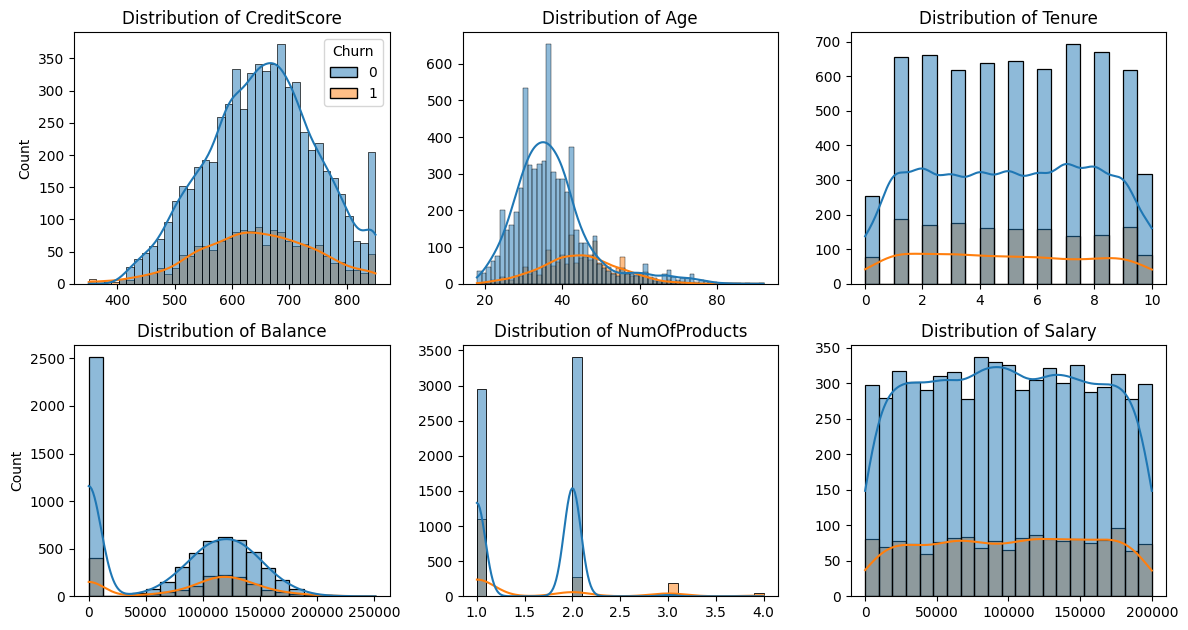

In [9]:
df = X.copy()
df["Churn"] = y["Churn"].astype(int)

ncols = 3
nrows = math.ceil(len(num_cols) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3.2 * nrows))
axes = np.array(axes).reshape(-1)

for i, col in enumerate(num_cols):
    ax = axes[i]
    sns.histplot(df, x=col, hue=target, kde=True, ax=ax)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel("")
    if i != 0:
        ax.get_legend().remove()
    if i not in [0,3]:
        ax.set_ylabel("")

fig.tight_layout()
plt.show()

# Save for LaTeX:
# fig.savefig("num_features_grid.png", dpi=300, bbox_inches="tight")

**Categorical Features:**

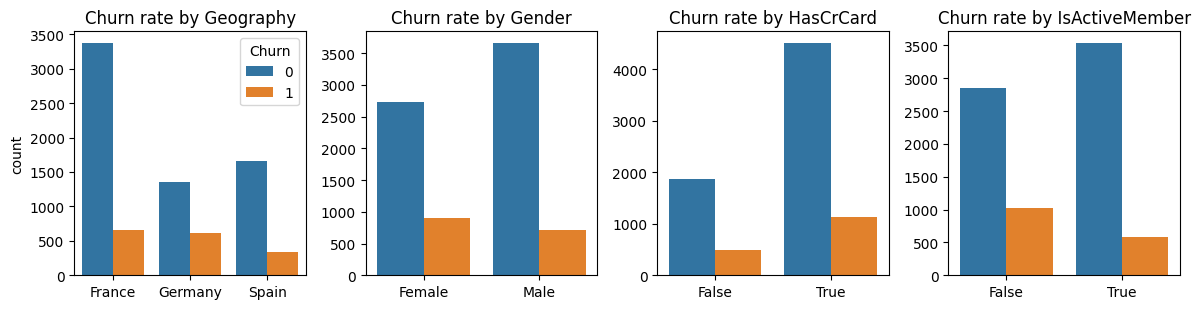

In [44]:
df = X.copy()
df["Churn"] = y["Churn"].astype(int)

ncols = 4
nrows = math.ceil(len(cat_cols) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3.2 * nrows))
axes = np.array(axes).reshape(-1)

for i, col in enumerate(cat_cols):
    if col == target:
        continue
        
    ax = axes[i]
    sns.countplot(data=df, x=col, hue=target, ax=ax)
    ax.set_title(f"Churn rate by {col}")
    ax.set_xlabel("")
    if i != 0:
        ax.get_legend().remove()
    if i not in [0]:
        ax.set_ylabel("")

fig.tight_layout()
plt.show()

# Save for LaTeX:
#fig.savefig("cat_features_grid.png", dpi=300, bbox_inches="tight")

In [ ]:
df = X.copy()

encoder = OneHotEncoder(sparse_output=False)
X_cat = encoder.fit_transform(df[cat_cols])
X_num = df[num_cols].values
X_encoded = np.hstack((X_num, X_cat))

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="random",
    random_state=0
)

X_tsne = tsne.fit_transform(X_encoded)

In [ ]:
for col in num_cols:
    plt.figure(figsize=(7,6))
    plt.title(f"t-SNE colored by {col}")
    plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df[col], cmap="viridis", alpha=0.7)
    plt.colorbar()
    plt.show()

## **Part II** - Data processing

In [9]:
X_cv, X_eval, y_cv, y_eval = train_test_split(X, y, test_size=1/8, random_state=42)

OHE = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_cv_cat = OHE.fit_transform(X_cv[cat_cols])
X_eval_cat = OHE.transform(X_eval[cat_cols])

scaler = StandardScaler()
X_cv_num = scaler.fit_transform(X_cv[num_cols])
X_eval_num = scaler.transform(X_eval[num_cols])

X_cv = np.hstack([X_cv_num, X_cv_cat])
X_eval = np.hstack([X_eval_num, X_eval_cat])

y_cv = y_cv.to_numpy().ravel()
y_eval = y_eval.to_numpy().ravel()

## **Part III - Model training**

In [142]:
logreg = LogisticRegression(solver="saga", max_iter=200, random_state=0)
logreg_dist = [
    {
        "penalty": ["l1", "l2"],
        "C": uniform(loc=0, scale=4)
    },
    {
        "penalty": ["elasticnet"],
        "C": uniform(loc=0, scale=4),
        "l1_ratio": uniform()
    }
]

logreg_clf = RandomizedSearchCV(logreg, logreg_dist, n_iter=100, random_state=0)
logreg_search = logreg_clf.fit(X_cv, y_cv)
logreg_eval_score = logreg_search.best_estimator_.score(X_eval, y_eval)
print(f"Logistic Regression cross-validation score: {logreg_search.best_score_:5f}")
print(f"Logistic Regression evaluation score: {logreg_eval_score:5f}")
print(f"Best parameters: {logreg_search.best_params_}")

Logistic Regression cross-validation score: 0.811714
Logistic Regression evaluation score: 0.814000
Best parameters: {'C': 0.1537017058909389, 'l1_ratio': 0.634274057957335, 'penalty': 'elasticnet'}


In [143]:
kNN = KNeighborsClassifier()
kNN_dist = dict(
    n_neighbors=range(1, 20),
    weights=["uniform", "distance"]
)

kNN_clf = GridSearchCV(kNN, kNN_dist)
kNN_search = kNN_clf.fit(X_cv, y_cv)
kNN_eval_score = kNN_search.best_estimator_.score(X_eval, y_eval)
print(f"k Neirest Neighbors cross-validation score: {kNN_search.best_score_:5f}")
print(f"k Neirest Neighbors evaluation score: {kNN_eval_score:5f}")
print(f"Best parameters: {kNN_search.best_params_}")

k Neirest Neighbors cross-validation score: 0.852857
k Neirest Neighbors evaluation score: 0.846000
Best parameters: {'n_neighbors': 18, 'weights': 'distance'}


In [144]:
LDA = LinearDiscriminantAnalysis(solver="lsqr")
LDA_dist = dict(
    shrinkage=uniform()
)

LDA_clf = RandomizedSearchCV(LDA, LDA_dist, n_iter=100)
LDA_search = LDA_clf.fit(X_cv, y_cv)
LDA_eval_score = LDA_search.best_estimator_.score(X_eval, y_eval)
print(f"Linear Discriminant Analysis cross-validation score: {LDA_search.best_score_:5f}")
print(f"Linear Discriminant Analysis evaluation score: {LDA_eval_score:5f}")
print(f"Best parameters: {LDA_search.best_params_}")

Linear Discriminant Analysis cross-validation score: 0.809143
Linear Discriminant Analysis evaluation score: 0.802000
Best parameters: {'shrinkage': 0.031861264296572656}


In [145]:
QDA = QuadraticDiscriminantAnalysis()
QDA_dist = dict(
    reg_param=uniform(),
)

QDA_clf = RandomizedSearchCV(QDA, QDA_dist, n_iter=100)
QDA_search = QDA_clf.fit(X_cv, y_cv)
QDA_eval_score = QDA_search.best_estimator_.score(X_eval, y_eval)
print(f"Quadratic Discriminant Analysis cross-validation score: {QDA_search.best_score_:5f}")
print(f"Quadratic Discriminant Analysis evaluation score: {QDA_eval_score:5f}")
print(f"Best parameters: {QDA_search.best_params_}")

Quadratic Discriminant Analysis cross-validation score: 0.836571
Quadratic Discriminant Analysis evaluation score: 0.839000
Best parameters: {'reg_param': 0.047137372486453666}


In [146]:
# gaussian_process = GaussianProcessClassifier()
# gaussian_process_dist = dict(
#     kernel=[RBF(), Matern(), RationalQuadratic(), ExpSineSquared()],  
# )

# gaussian_process_clf = RandomizedSearchCV(gaussian_process, gaussian_process_dist)
# gaussian_process_search = gaussian_process_clf.fit(X_cv, y_cv)
# gaussian_process_eval_score = gaussian_process_search.best_estimator_.score(X_eval, y_eval)
# print(f"Support Vector Classification evaluation score: {gaussian_process_eval_score:5f}")
# print(f"Best parameters: {gaussian_process_search.best_params_}")

In [147]:
svc = SVC()
svc_dist = [
    {
        "kernel": ["poly"],
        "C": uniform(loc=0, scale=4),
        "degree": range(1, 5)
    },
    {
        "kernel": ["rbf", "sigmoid"],
        "C": uniform(loc=0, scale=4),
    }
]

svc_clf = RandomizedSearchCV(svc, svc_dist)
svc_search = svc_clf.fit(X_cv, y_cv)
svc_eval_score = svc_search.best_estimator_.score(X_eval, y_eval)
print(f"Support Vector Classification cross-validation score: {svc_search.best_score_:5f}")
print(f"Support Vector Classification evaluation score: {svc_eval_score:5f}")
print(f"Best parameters: {svc_search.best_params_}")

Support Vector Classification cross-validation score: 0.860714
Support Vector Classification evaluation score: 0.850000
Best parameters: {'C': 2.1600886336374576, 'kernel': 'rbf'}


In [148]:
GNB = GaussianNB()
GNB_dist = {
    "var_smoothing": uniform(loc=0, scale=1e-3)
}

GNB_clf = RandomizedSearchCV(GNB, GNB_dist, n_iter=100)
GNB_search = GNB_clf.fit(X_cv, y_cv)
GNB_eval_score = GNB_search.best_estimator_.score(X_eval, y_eval)
print(f"Gaussian Naive Bayes cross-validation score: {GNB_search.best_score_:5f}")
print(f"Gaussian Naive Bayes evaluation score: {GNB_eval_score:5f}")
print(f"Best parameters: {GNB_search.best_params_}")

Gaussian Naive Bayes cross-validation score: 0.825571
Gaussian Naive Bayes evaluation score: 0.827000
Best parameters: {'var_smoothing': 0.0003055515495910056}


In [149]:
# grad_boost = GradientBoostingClassifier()
# grad_boost_dist = {
#     "loss": ["log_loss", "deviance", "exponential"],
#     "learning_rate": uniform(loc=1e-6, scale=1e-2),
#     "n_estimators": [100, 200, 300, 400],
#     "max_depth": [3, 5, 7, 9]
# }

# grad_boost_clf = RandomizedSearchCV(grad_boost, grad_boost_dist, n_iter=100)
# grad_boost_search = grad_boost_clf.fit(X_cv, y_cv)
# grad_boost_eval_score = grad_boost_search.best_estimator_.score(X_eval, y_eval)
# print(f"Gaussian Naive Bayes evaluation score: {grad_boost_eval_score:5f}")
# print(f"Best parameters: {grad_boost_search.best_params_}")

In [150]:
hist_grad_boost = HistGradientBoostingClassifier(max_iter=200)
hist_grad_boost_dist = {
    "learning_rate": uniform(loc=1e-6, scale=1e-2),
    "max_depth": [3, 5, 7, 9, 11],
    "l2_regularization": uniform()
}

hist_grad_boost_clf = RandomizedSearchCV(hist_grad_boost, hist_grad_boost_dist, n_iter=20)
hist_grad_boost_search = hist_grad_boost_clf.fit(X_cv, y_cv)
hist_grad_boost_eval_score = hist_grad_boost_search.best_estimator_.score(X_eval, y_eval)
print(f"Histogram Gradient Boosting cross-validation score: {hist_grad_boost_search.best_score_:5f}")
print(f"Histogram Gradient Boosting evaluation score: {hist_grad_boost_eval_score:5f}")
print(f"Best parameters: {hist_grad_boost_search.best_params_}")

Histogram Gradient Boosting cross-validation score: 0.864714
Histogram Gradient Boosting evaluation score: 0.854000
Best parameters: {'l2_regularization': 0.26378353528908427, 'learning_rate': 0.009799923727335973, 'max_depth': 7}


In [151]:
RF = RandomForestClassifier()
RF_dist = {
    "max_depth": [3, 5, 7, 9, 11, 13],
    "n_estimators": [100, 200, 300, 400],
    "min_samples_split": [2, 5, 10, 15],
}

RF_clf = RandomizedSearchCV(RF, RF_dist, n_iter=20)
RF_search = RF_clf.fit(X_cv, y_cv)
RF_eval_score = RF_search.best_estimator_.score(X_eval, y_eval)
print(f"Random Forest cross-validation score: {RF_search.best_score_:5f}")
print(f"Random Forest evaluation score: {RF_eval_score:5f}")
print(f"Best parameters: {RF_search.best_params_}")

Random Forest cross-validation score: 0.867571
Random Forest evaluation score: 0.857000
Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 13}


In [152]:
extratrees = ExtraTreesClassifier()
extratrees_dist = {
    "max_depth": [3, 5, 7, 9, 11, 13],
    "n_estimators": [100, 200, 300, 400],
    "min_samples_split": [2, 5, 10, 15],
}

extratrees_clf = RandomizedSearchCV(extratrees, extratrees_dist, n_iter=20)
extratrees_search = extratrees_clf.fit(X_cv, y_cv)
extratrees_eval_score = extratrees_search.best_estimator_.score(X_eval, y_eval)
print(f"Extra Trees cross-validation score: {extratrees_search.best_score_:5f}")
print(f"Extra Trees evaluation score: {extratrees_eval_score:5f}")
print(f"Best parameters: {extratrees_search.best_params_}")

Extra Trees cross-validation score: 0.863857
Extra Trees evaluation score: 0.843000
Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 13}


In [153]:
rf_adaboost = RandomForestClassifier(n_estimators=50, min_samples_split=10, max_depth=5)
adaboost_rf = AdaBoostClassifier(estimator=rf_adaboost, learning_rate=0.7).fit(X_cv, y_cv)
print(f"Adaboost + RF training score: {adaboost_rf.score(X_cv, y_cv):5f}")
print(f"Adaboost + RF evaluation score: {adaboost_rf.score(X_eval, y_eval):5f}")

Adaboost + RF training score: 0.996000
Adaboost + RF evaluation score: 0.827000


## **Part IV - Model Choice**

In [20]:
RF = RandomForestClassifier(n_estimators = 200, min_samples_split=10, max_depth=11 )
RF.fit(X_cv, y_cv)

RandomForestClassifier(max_depth=11, min_samples_split=10, n_estimators=200)

#### **1. Confusion Matrix**

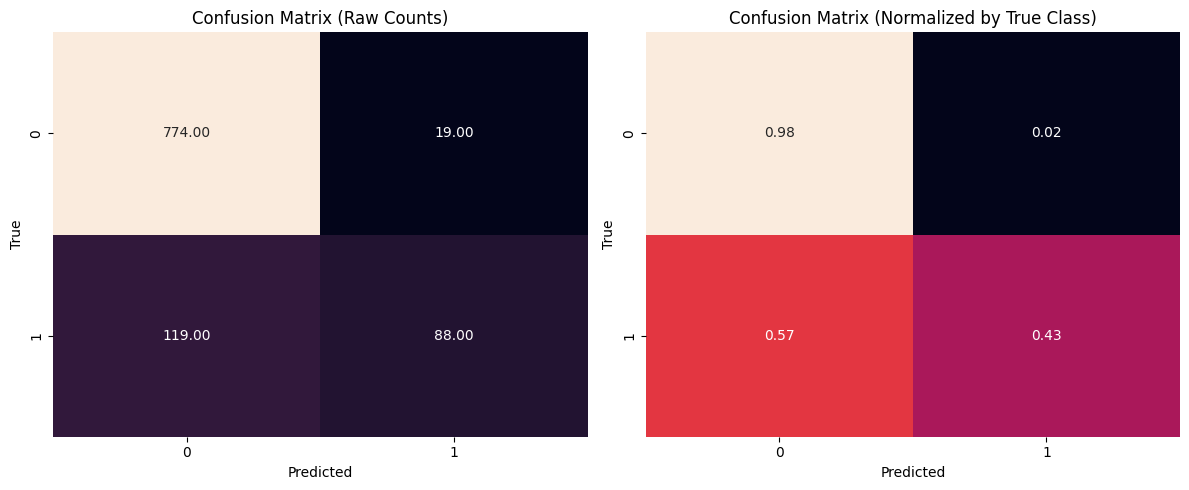

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = RF.predict(X_eval)
cm_raw = confusion_matrix(y_eval, y_pred)
cm_norm = confusion_matrix(y_eval, y_pred, normalize='true')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(
    cm_raw,
    annot=True,
    fmt=".2f",
    ax=axes[0],cbar=False,
)
axes[0].set_title("Confusion Matrix (Raw Counts)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    ax=axes[1],cbar=False,
)
axes[1].set_title("Confusion Matrix (Normalized by True Class)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

#### **2. Confusion matrix per col**

In [134]:
_, X_eval_raw, _, _ = train_test_split(X, y, test_size=1/8, random_state=42)
eval_df = pd.DataFrame(X_eval_raw, columns=X.columns)
eval_df["true"] = y_eval
eval_df["pred"] = y_pred

eval_df["segment"] = np.select(
    [
        (eval_df["true"] == 1) & (eval_df["pred"] == 1),  # TP
        (eval_df["true"] == 1) & (eval_df["pred"] == 0),  # FN
        (eval_df["true"] == 0) & (eval_df["pred"] == 1),  # FP
        (eval_df["true"] == 0) & (eval_df["pred"] == 0),  # TN
    ],
    ["TP", "FN", "FP", "TN"]
)

eval_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Salary,true,pred,segment
2215,796,Germany,Male,39,5,86350.87,2,False,False,105081,False,False,TN
2582,624,France,Male,36,6,0.00,2,False,False,84750,False,False,TN
1662,742,Spain,Male,24,8,0.00,2,True,False,4070,False,False,TN
3027,850,Spain,Male,22,3,0.00,1,True,True,144386,False,False,TN
4343,645,Germany,Female,37,2,136925.09,2,False,True,153400,False,False,TN


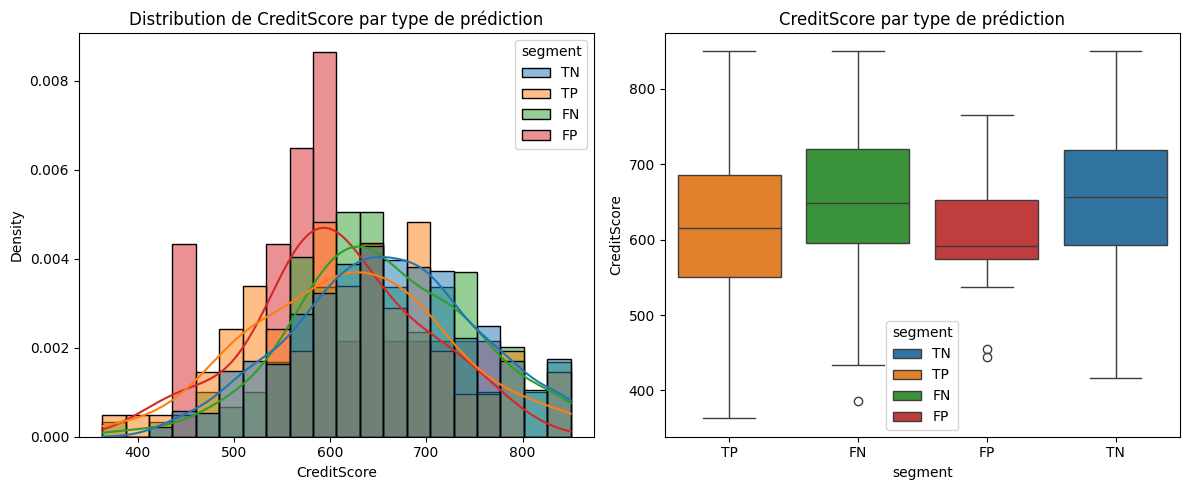

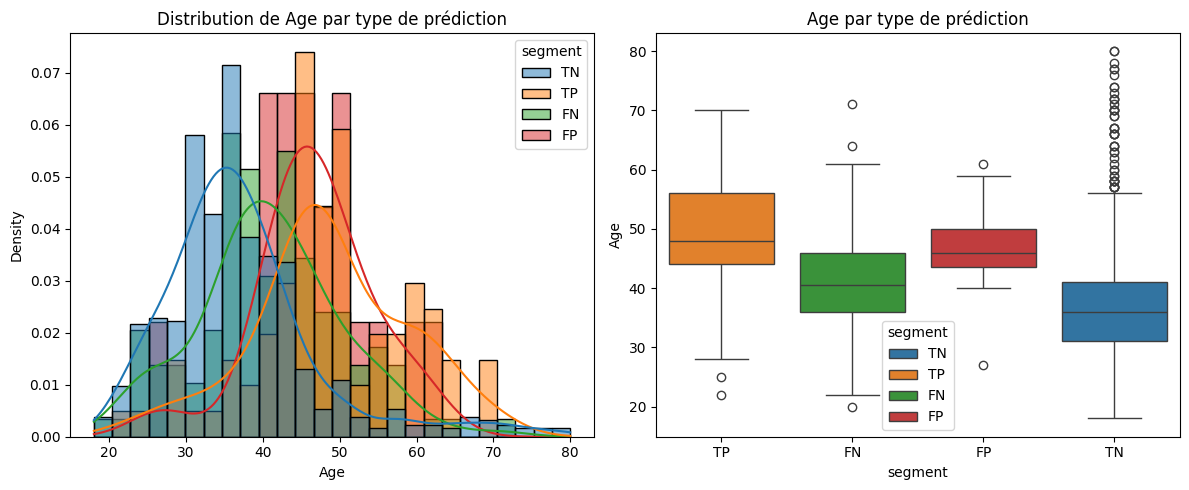

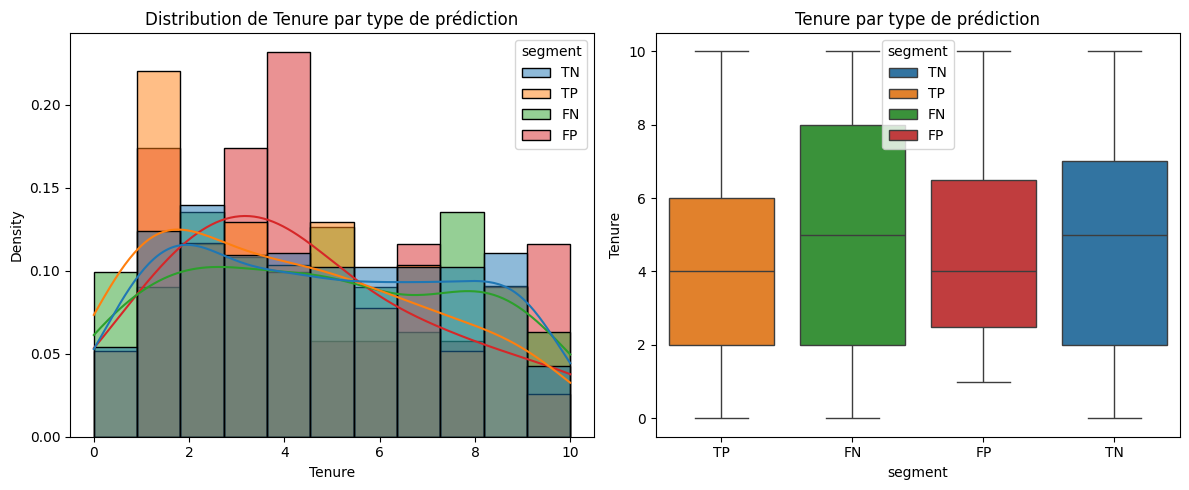

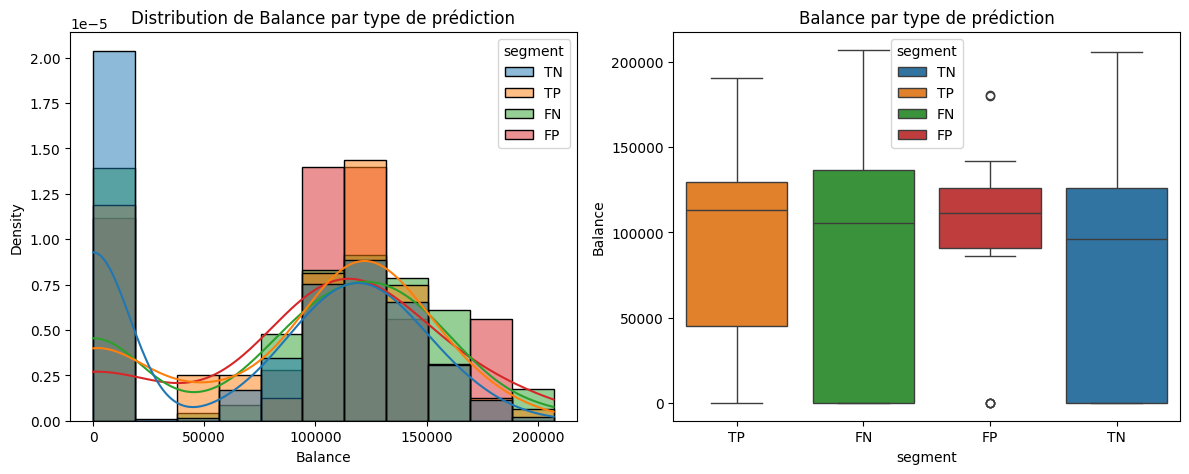

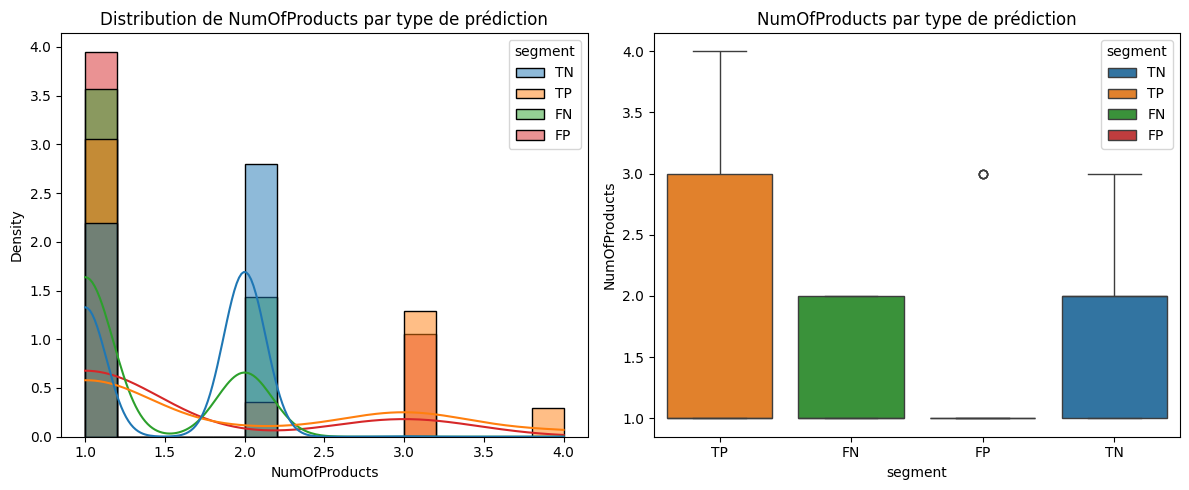

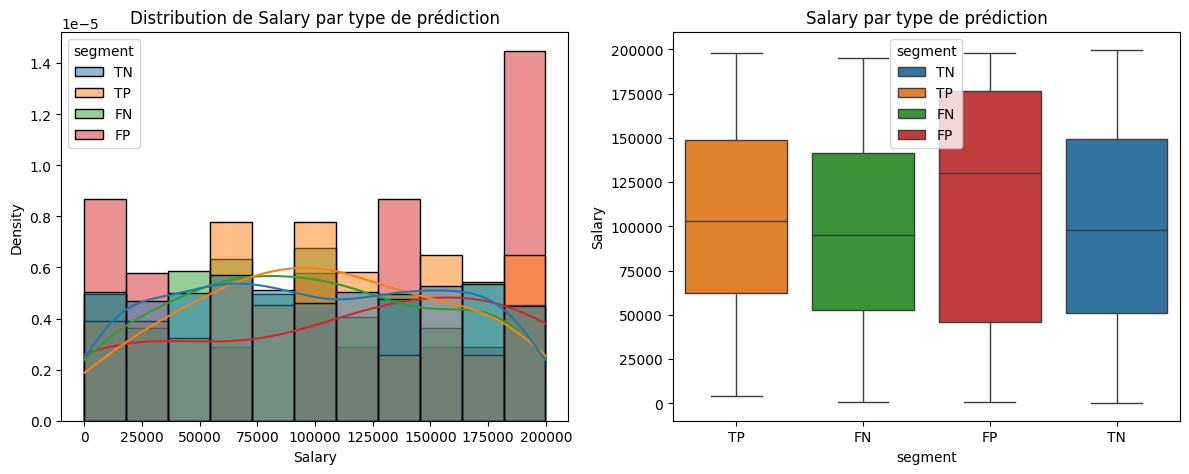

In [135]:

for col in num_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12,5))

    #first plot 
    sns.histplot(
        data=eval_df,
        x=col,
        hue="segment",
        kde=True,
        stat="density",
        common_norm=False,
        multiple="layer",  # ou "stack"
        ax=ax[0]
    )
    ax[0].set_title(f"Distribution de {col} par type de prédiction")
    
    sns.boxplot(data=eval_df,
                x="segment", 
                hue="segment",
                y=col, 
                order=["TP", "FN", "FP", "TN"], 
                ax = ax[1],
                legend = True)
    ax[1].set_title(f"{col} par type de prédiction")
    
    plt.tight_layout()
    plt.show()



C:\Users\Massil\AppData\Local\Temp\ipykernel_12536\1616052975.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = eval_df.groupby(col)["segment"].value_counts(normalize=True).rename("proportion")


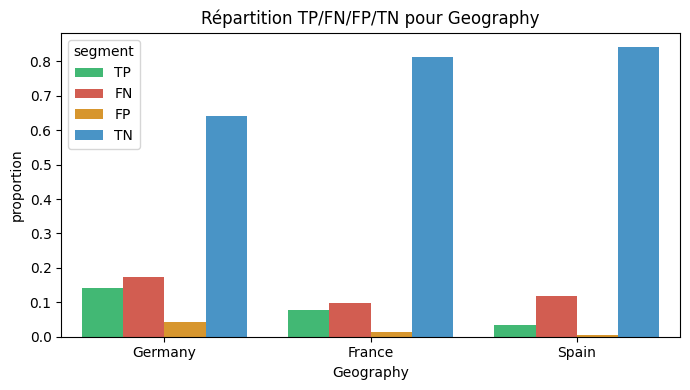

C:\Users\Massil\AppData\Local\Temp\ipykernel_12536\1616052975.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = eval_df.groupby(col)["segment"].value_counts(normalize=True).rename("proportion")


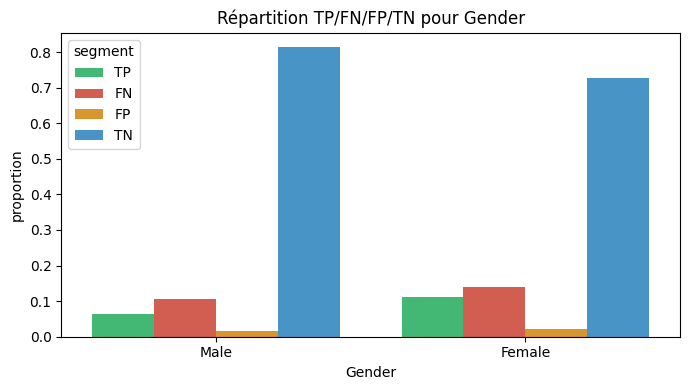

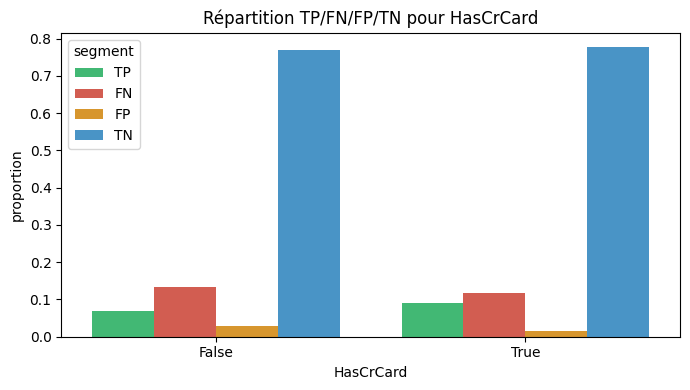

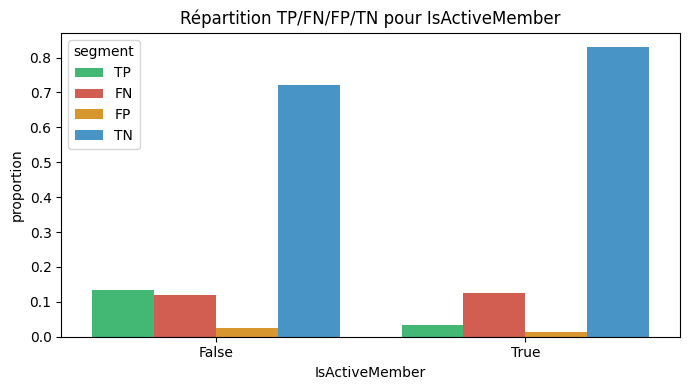

In [136]:

for col in cat_cols:
    temp = eval_df.groupby(col)["segment"].value_counts(normalize=True).rename("proportion")

    temp = temp.reset_index()

    plt.figure(figsize=(7,4))
    sns.barplot(
        data=temp,
        x=col,
        y="proportion",
        hue="segment",
        order=eval_df[col].unique(),
        hue_order=["TP","FN","FP","TN"],
        palette={
            "TP": "#2ecc71",
            "FN": "#e74c3c",
            "FP": "#f39c12",
            "TN": "#3498db",
        }
    )
    plt.title(f"Répartition TP/FN/FP/TN pour {col}")
    plt.tight_layout()
    plt.show()


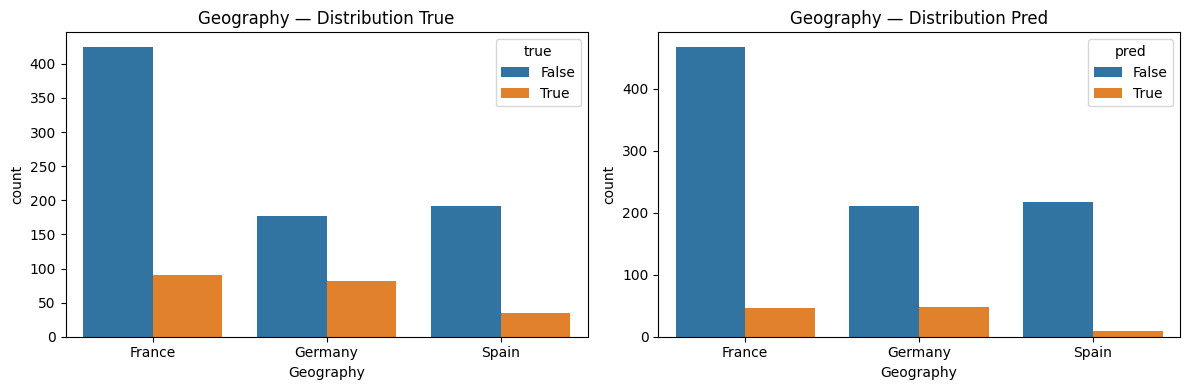

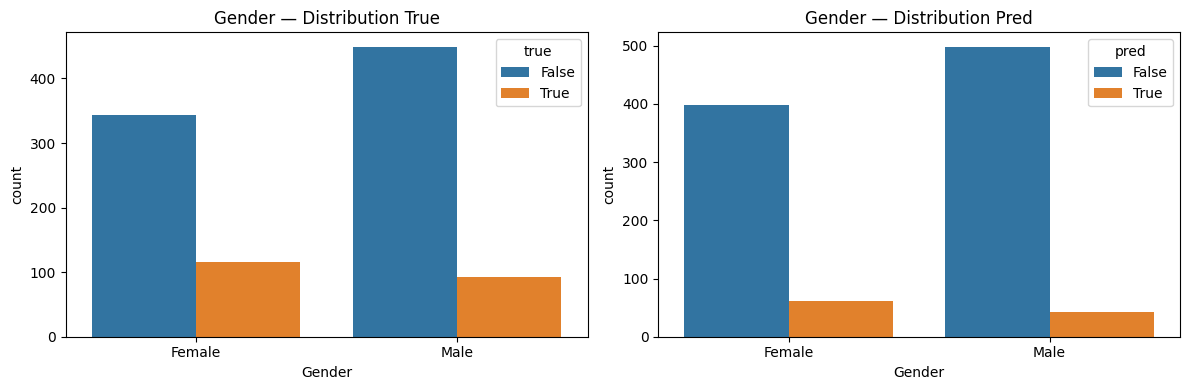

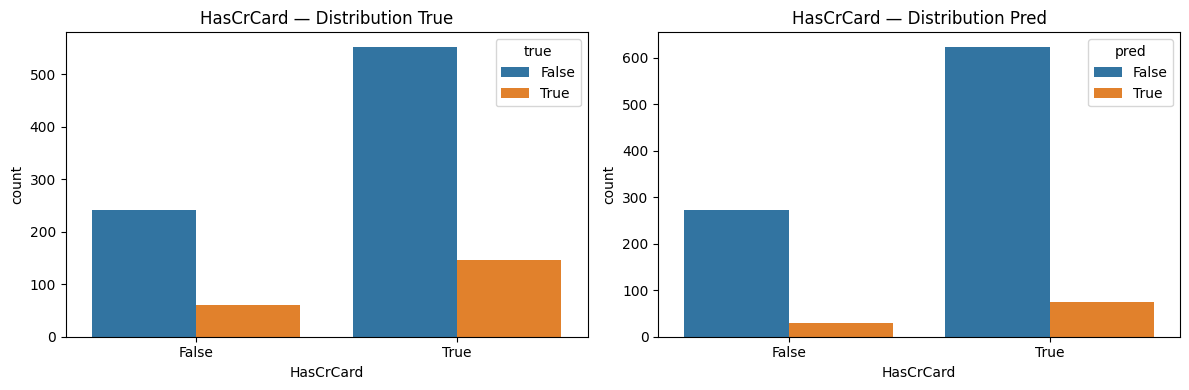

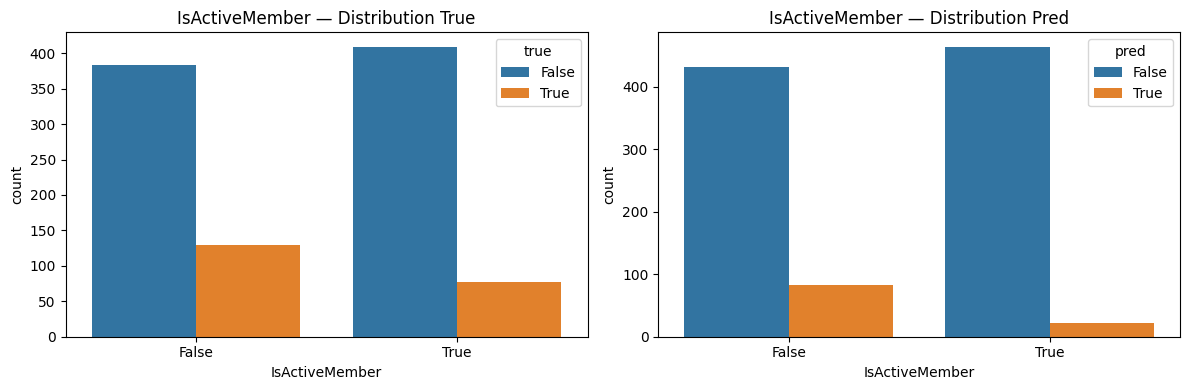

In [137]:
for col in cat_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12,4))

    sns.countplot(
        data=eval_df,
        x=col,
        hue="true",
        ax=ax[0]
    )
    ax[0].set_title(f"{col} — Distribution True")

    sns.countplot(
        data=eval_df,
        x=col,
        hue="pred",
        ax=ax[1]
    )
    ax[1].set_title(f"{col} — Distribution Pred")

    plt.tight_layout()
    plt.show()


#### 3. ROC Curve

In [139]:
from sklearn.metrics import roc_curve, roc_auc_score
# Probabilité prédite du churn (classe 1)
y_proba = RF_search.best_estimator_.predict_proba(X_eval)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_eval, y_proba)
auc = roc_auc_score(y_eval, y_proba)


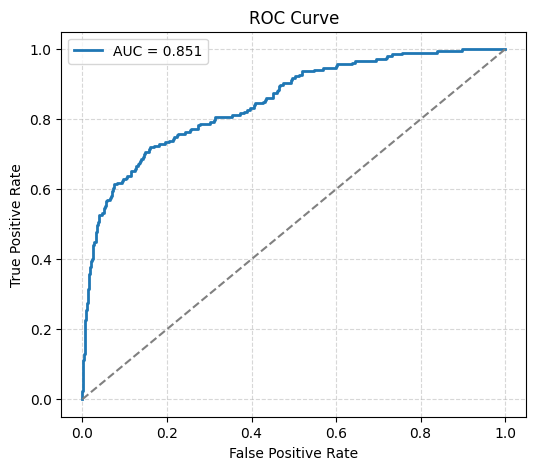

In [140]:
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)
plt.plot([0,1], [0,1], "--", color="gray")  # random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

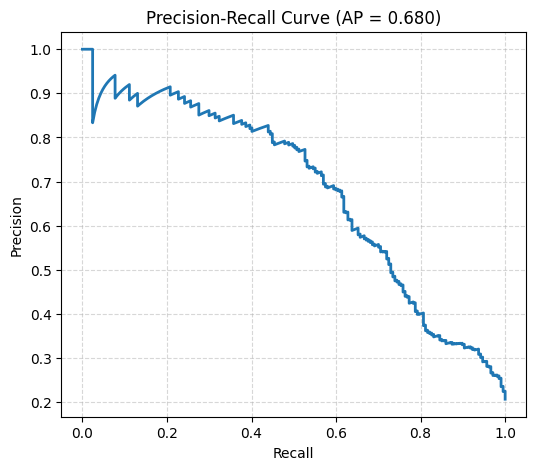

In [141]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_eval, y_proba)
ap = average_precision_score(y_eval, y_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AP = {ap:.3f})")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


## **Part V - Fairness**

In [29]:
RF = RandomForestClassifier(n_estimators = 200, min_samples_split=10, max_depth=11 )
RF.fit(X_cv, y_cv)
y_pred = RF.predict(X_eval)
y_proba = RF.predict_proba(X_eval)[:, 1]

_, X_eval_raw, _, _ = train_test_split(X, y, test_size=1/8, random_state=42)
df_eval = pd.DataFrame(X_eval_raw, columns=X.columns)
gender  = df_eval["Gender"].values 

**Independence**

In [40]:
gender = np.asarray(gender)
y_true = np.asarray(y_eval)
y_pred = np.asarray(y_pred)
y_proba = np.asarray(y_proba)

mask_F = (gender == "Female")
mask_M = (gender == "Male")
pr_F = (y_pred[mask_F] == pos_label).mean()
pr_M = (y_pred[mask_M] == pos_label).mean()

dp_diff  = pr_F - pr_M

print("=== Independence (Demographic Parity) ===")
print(f"P(Ŷ=1 | Female) = {pr_a:.3f}")
print(f"P(Ŷ=1 | Male) = {pr_b:.3f}")
print(f"Diff = {dp_diff:.3f}")

=== Independence (Demographic Parity) ===
P(Ŷ=1 | Female) = 0.083
P(Ŷ=1 | Male) = 0.137
Diff = 0.054


**Separation**

In [41]:
def tpr_fpr(y_t, y_p):
    tn, fp, fn, tp = confusion_matrix(y_t, y_p, labels=[0, 1]).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan   # recall
    fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
    return tpr, fpr

tpr_F, fpr_F = tpr_fpr(y_true[mask_F], y_pred[mask_F])
tpr_M, fpr_M = tpr_fpr(y_true[mask_M], y_pred[mask_M])

print("\n=== Separation (Equalized Odds) ===")
print(f"TPR {'Female'}: {tpr_F:.3f}, TPR {'Male'}: {tpr_M:.3f}, Diff: {(tpr_F - tpr_M):.3f}")
print(f"FPR {'Female'}: {fpr_F:.3f}, FPR {'Male'}: {fpr_M:.3f}, Diff: {(fpr_F - fpr_M):.3f}")


=== Separation (Equalized Odds) ===
TPR Female: 0.461, TPR Male: 0.391, Diff: 0.070
FPR Female: 0.029, FPR Male: 0.020, Diff: 0.009


**Sufficiency**

In [45]:
bins = np.linspace(0, 1, 6)  # 5 bins: [0,0.2)...[0.8,1]

def calibration_table(y_t, y_p):
    df = pd.DataFrame({"y": y_t, "proba": y_p})
    df["bin"] = pd.cut(df["proba"], bins=bins, include_lowest=True)
    calib = df.groupby("bin").agg(
        mean_score=("proba", "mean"),
        emp_pos_rate=("y", "mean"),
        count=("y", "size")
    )
    return calib

calib_F = calibration_table(y_true[mask_F], y_proba[mask_F])
calib_M = calibration_table(y_true[mask_M], y_proba[mask_M])

brier_F = brier_score_loss(y_true[mask_F], y_proba[mask_F])
brier_M = brier_score_loss(y_true[mask_M], y_proba[mask_M])

print("\n=== Sufficiency (Calibration) ===")
print(f"Brier score Female: {brier_F:.4f}")
print(f"Brier score Male: {brier_M:.4f}")
print("\nCalibration table - Female")
print(calib_F)
print("\nCalibration table - Male")
print(calib_M)



=== Sufficiency (Calibration) ===
Brier score Female: 0.1214
Brier score Male: 0.0958

Calibration table - Female
               mean_score  emp_pos_rate  count
bin                                           
(-0.001, 0.2]    0.090762      0.084615    260
(0.2, 0.4]       0.280851      0.268293    123
(0.4, 0.6]       0.514368      0.645161     31
(0.6, 0.8]       0.705368      0.863636     22
(0.8, 1.0]       0.858830      0.913043     23

Calibration table - Male
               mean_score  emp_pos_rate  count
bin                                           
(-0.001, 0.2]    0.076974      0.074813    401
(0.2, 0.4]       0.269654      0.252874     87
(0.4, 0.6]       0.522852      0.666667     24
(0.6, 0.8]       0.691999      0.850000     20
(0.8, 1.0]       0.879600      0.777778      9


C:\Users\Massil\AppData\Local\Temp\ipykernel_5220\1501225675.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df.groupby("bin").agg(
C:\Users\Massil\AppData\Local\Temp\ipykernel_5220\1501225675.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df.groupby("bin").agg(
